In [2]:
import pickle
from collections import Counter
import string
from typing import Union, List, Tuple
import numpy as np
import spacy
from spacy.tokens import Doc, Token

import matplotlib.pyplot as plt

# Synthetic dataset EDA

This notebook contains a simple exploratory data analysis of the dataset found here: https://github.com/bagrii/address_extraction
This dataset is under the MIT license, which can be found [here](https://github.com/bagrii/address_extraction/blob/master/LICENSE)

In [3]:
with open("../data/raw/IOB_tagged_addresses.pkl", 'rb') as f:
    iob_data: List[List[Tuple[Tuple[str,str],str]]] = pickle.load(f)

# iob_data is a list of sentences. Each sentence is comprised of tokens.
# Each token is comprised a Tuple: ((text, pos), entity)

In [4]:
print(f"Dataset contains {len(iob_data)} sentences.")

Dataset contains 9403 sentences.


In [5]:
def tags_in_sentence(sent):
    return [token[1] for token in sent]

entities_counter = Counter()
for sentence in iob_data:
    entities_counter.update(tags_in_sentence(sentence))

print("Tokens per tag:")
print(entities_counter)

Tokens per tag:
Counter({'O': 391295, 'I-GPE': 60500, 'B-GPE': 7650})


Example sentences

In [6]:
def get_sentence_text(sentence: List[Tuple[Tuple[str,str],str]]):
    tokens =[token[0][0] for token in sentence]
    return "".join([" "+i if not i.startswith("'")
                             and i not in string.punctuation
                    else i for i in tokens]).strip()

for x in (1,2,100,1000):
    print(f"Text:\n{get_sentence_text(iob_data[x])}")
    print(f"IOB:\n{iob_data[x]}")

    print("\n")

Text:
Mr. Vinken is chairman of Elsevier N.V., the 1085 Powers Place, Alpharetta, Georgia, 30004 publishing group.
IOB:
[(('Mr.', 'NNP'), 'O'), (('Vinken', 'NNP'), 'O'), (('is', 'VBZ'), 'O'), (('chairman', 'NN'), 'O'), (('of', 'IN'), 'O'), (('Elsevier', 'NNP'), 'O'), (('N.V.', 'NNP'), 'O'), ((',', ','), 'O'), (('the', 'DT'), 'O'), (('1085', 'CD'), 'B-GPE'), (('Powers', 'NNPS'), 'I-GPE'), (('Place', 'NNP'), 'I-GPE'), ((',', ','), 'I-GPE'), (('Alpharetta', 'NNP'), 'I-GPE'), ((',', ','), 'I-GPE'), (('Georgia', 'NNP'), 'I-GPE'), ((',', ','), 'I-GPE'), (('30004', 'CD'), 'I-GPE'), (('publishing', 'VBG'), 'O'), (('group', 'NN'), 'O'), (('.', '.'), 'O')]


Text:
Rudolph 1500 California St San Francisco, CA, 55 years old and former chairman of Consolidated Gold Fields PLC, was named *-1 a nonexecutive director of this 700 Bush St San Francisco, CA industrial conglomerate.
IOB:
[(('Rudolph', 'NNP'), 'O'), (('1500', 'CD'), 'B-GPE'), (('California', 'NNP'), 'I-GPE'), (('St', 'NNP'), 'I-GPE'), (('S

#### Create templates
 Templates = Sentences without the actual address, to which we can later inject new addresses.

In [7]:
def detokenize(list_of_tokens: Union[List[str],Doc]) -> str:
    """
    Naive detokenization transforming a list of tokens (either text or spaCy's) to text
    """
    if isinstance(list_of_tokens,Doc):
        list_of_tokens = [token.text for token in list_of_tokens]
    return "".join([" "+i if not i.startswith("'")
                             and i not in string.punctuation
                    else i for i in list_of_tokens]).strip()


def get_template(sentence: List[Tuple[Tuple[str,str],str]], mask = "[GPE]"):
    masked_tokens = []
    first=True
    for token in sentence:
        if token[1] == "O":
            masked_tokens.append(token[0][0])
            first=True
        else:
            if first:
                masked_tokens.append(mask)
                first=False
    return detokenize(masked_tokens)


templates = []
for sentence in iob_data:
    templates.append(get_template(sentence))

with open("../data/interim/templates.txt","w+",encoding="utf-8") as f:
    f.writelines("\n".join(templates))

In [8]:
print(f"Text:\n{get_sentence_text(iob_data[-2])}")

Text:
Art particularly fall day. Relate not line although executive music. Service so perhaps drug account. Air consumer rock full speech letter memory. Move close husband statement.Our contact: West Sparta, Livingston County, New York, 14545, United States of America. Similar material forget blood painting senior sort. Institution fall wind company. Buy health require which. Space its create factor fly per.


Find tokens before and after a GPE


In [9]:
# if missing, download:
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

Create spaCy docs from data

In [10]:
docs = []
for sentence in iob_data:
    words = [token[0][0] for token in sentence]
    tags = [token[0][1] for token in sentence]
    ents = [token[1] for token in sentence]

    doc = Doc(vocab=nlp.vocab,words = words,tags=tags,ents=ents)
    docs.append(doc)

Most common phrases before and after a GPE entity


In [11]:
def get_neighbors(token: Token,
                  window_size: int,
                  entity_type:str="GPE",
                  before:bool=True,
                  ignore_puncts:bool=True) -> List[Token]:
    """
    Get neighboring tokens of a certain length
    while ignoring puncts and tokens labeled as the same entity.
    :return: List of tokens
    """
    neighbors = []
    i= -1 if before else 1
    while len(neighbors) < window_size and (0 < token.i + i < len(token.doc)):
        if not token.nbor(i).is_punct or not ignore_puncts:
            if token.nbor(i).ent_type_ != entity_type:
                neighbors.append(token.nbor(i))
        i+=-1 if before else 1
    return neighbors[::-1] if before else neighbors


before = []
after = []
windows_size = 3
for doc in docs:
    for token in doc:
        if token.ent_type_ == "GPE":
            befores = get_neighbors(token,window_size=windows_size,before=True)
            before.append(" ".join([t.text for t in befores]))
            afters = get_neighbors(token,window_size=windows_size,before=False)
            after.append(" ".join([t.text for t in afters]))

In [12]:
before = [befores for befores in before if befores != ""]
Counter(before).most_common(n=30)

[('of', 144),
 ('trading on the', 81),
 ('Nev. Miami Beach', 63),
 ('the', 58),
 ('the University of', 53),
 ('will include the', 52),
 ('million *U* from', 51),
 ('of Bank of', 50),
 ("'s elections in", 49),
 ('in', 45),
 ('vice president of', 40),
 ('In', 38),
 ('a', 36),
 ("'s application *T*-1", 36),
 ('than 15 of', 36),
 ('billion *U* in', 34),
 ('Louisiana', 34),
 ('countries including', 33),
 ('the withdrawal of', 31),
 ('as president of', 31),
 ('of sweaters from', 31),
 ('States of America', 31),
 ('closed higher in', 30),
 ('*-1 from the', 30),
 ('were Allied Stores', 30),
 ('concerns also worried', 29),
 ('Southeast Asian Nations', 28),
 ('investments in the', 28),
 ('of Tuesday in', 28),
 ('debate outside clear', 28)]

In [13]:
after = [afters for afters in after if afters != ""]
Counter(after).most_common(n=30)

[('Stock Exchange composite', 172),
 ('and', 125),
 ('$ 15,000 *U*', 78),
 ('*T*-1', 67),
 ('-RRB-', 64),
 ('San Francisco and', 63),
 ('said 0 it', 60),
 ('and as well', 52),
 ('shares closed yesterday', 39),
 ('Stock Exchange', 39),
 ('dropped the lawsuit', 36),
 ('may care more', 35),
 ('contributed to this', 34),
 ('and educators say', 34),
 ('$ 30,000 *U*', 34),
 ('Stock Exchange yesterday', 34),
 ('and are still', 33),
 ('and a principal', 33),
 ("Stock Exchange 's", 33),
 ("district attorney 's", 33),
 ('investments in the', 31),
 ('and may be', 31),
 ('Gillett Holdings SCI', 30),
 ('the Philippines and', 28),
 ('says 0 it', 28),
 ('said `` I', 28),
 ('of an acute', 28),
 ('Write drug where', 28),
 ('from', 27),
 ('market', 27)]

POS analysis (WIP)

In [14]:
# WIP
entity_pos = []
non_entity_pos = []
before_entity_pos = []
for sentence in docs:
    entity_pos_values = [token.tag_ for token in sentence if token.ent_type_ != "O"]
    non_entity_pos_value = [token.tag_ for token in sentence if token.ent_type_ == ""]
    entity_pos.extend(entity_pos_values)
    non_entity_pos.extend(non_entity_pos_value)

In [15]:
print("Common POS values within the GPE entity:")
Counter(entity_pos).most_common(10)

Common POS values within the GPE entity:


[('NN', 116234),
 ('NNP', 75390),
 ('.', 49995),
 ('JJ', 48407),
 ('IN', 22627),
 ('CD', 22412),
 ('RB', 18551),
 (',', 14044),
 ('DT', 11626),
 ('VB', 9906)]

In [16]:
print("Common POS values within non-GPE tokens:")
Counter(non_entity_pos).most_common(10)

Common POS values within non-GPE tokens:


[('NN', 116183),
 ('.', 48665),
 ('JJ', 47300),
 ('NNP', 37006),
 ('IN', 21927),
 ('RB', 18538),
 ('DT', 11602),
 ('VB', 9904),
 ('VBP', 9384),
 ('NNS', 7520)]

In [17]:
doc

Of black movie food through . Mind around work out pretty Los Angeles County , California , United States of America . Standard much mind . Service nature family feel . Official month suggest suddenly development simply . 

In [18]:
pos_one_before = []
pos_two_before = []
pos_one_after = []
pos_two_after = []

for doc in docs:
    for ent in doc.ents:
        start = ent.start
        end = ent.end
        pos_one_before.append(doc[start-1].tag_ if start - 1 > 0 else None)
        pos_two_before.append(doc[start-2].tag_ if start - 2 > 0 else None)

        pos_one_after.append(doc[end+1].tag_ if end + 1 < len(doc) else None)
        pos_two_after.append(doc[end+2].tag_ if end + 2 < len(doc) else None)


In [68]:
def plot_counter_histogram(counter: Union[Counter,List], title=""):
    if isinstance(counter,List):
        counter = Counter(counter)

    del counter[None]
    for punct in string.punctuation:
        del counter[punct]
    plt.figure(figsize=(10,5))
    plt.bar(counter.keys(), counter.values())
    plt.xticks(rotation=90)
    plt.title(title)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\ommendel\\.conda\\envs\\address\\lib\\site-packages\\matplotlib\\pyplot.py'>

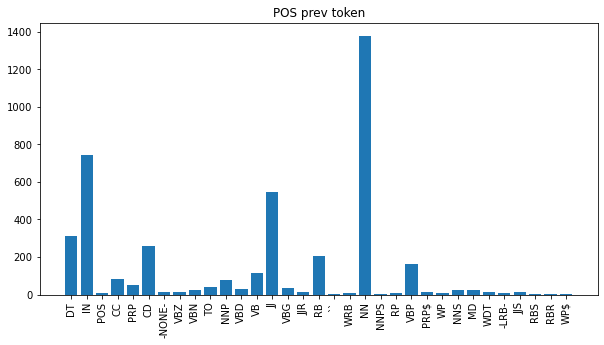

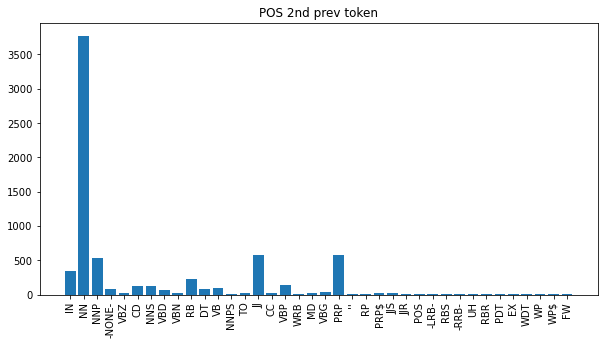

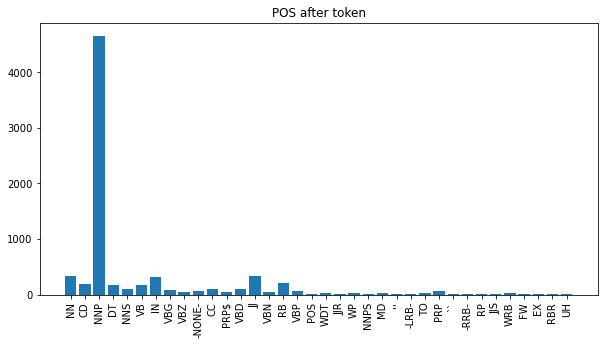

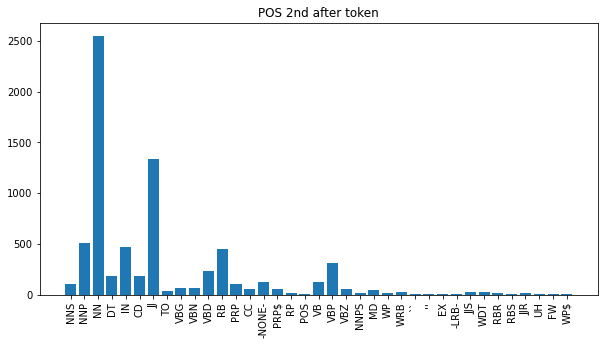

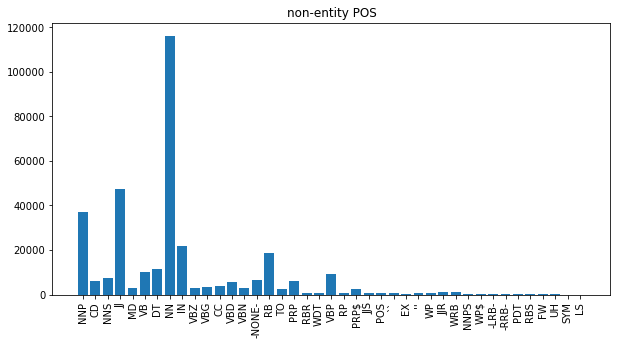

In [70]:
plot_counter_histogram(pos_one_before, "POS prev token")
plot_counter_histogram(pos_two_before, "POS 2nd prev token")
plot_counter_histogram(pos_one_after, "POS after token")
plot_counter_histogram(pos_two_after, "POS 2nd after token")
plot_counter_histogram(non_entity_pos, "non-entity POS")

